In [1094]:
import streamlit as st
import pandas as pd
# import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
# from nba_defs import draw_court
# import os
import pickle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn import tree
from xgboost import XGBClassifier

In [1095]:
# import data
url = 'https://raw.githubusercontent.com/rich-thai/Streamlit-on-Heroku/master/data.csv'
df = pd.read_csv(url, index_col=0).reset_index()
submission_df = df[df['shot_made_flag'].isnull()]

In [1096]:
# cleaning the data
df['away'] = df['matchup'].str.contains('@')
df['period_seconds_remaining'] = df['minutes_remaining']*60 + df['seconds_remaining']
df['last_seconds'] = (df['period_seconds_remaining']<=10)
df['shot_distance'] = df['shot_distance'].clip(0,35)

In [1097]:
action_count = df['action_type'].value_counts()

In [1098]:
df['action'] = df.apply(lambda x: x['action_type'] if action_count[x['action_type']]>20 else x['combined_shot_type'], axis=1)

In [1099]:
df.drop(columns=['team_id','team_name','matchup','game_date','lat','lon','shot_id','game_event_id',
                 'seconds_remaining', 'game_id','loc_x','loc_y','action_type','combined_shot_type'], axis=1, inplace=True)

In [1100]:
df.head()

,minutes_remaining,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,away,period_seconds_remaining,last_seconds,action
0,10,1,0,2000-01,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,True,627,False,Jump Shot
1,10,1,0,2000-01,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,True,622,False,Jump Shot
2,7,1,0,2000-01,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,True,465,False,Jump Shot
3,6,1,0,2000-01,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,True,412,False,Jump Shot
4,6,2,0,2000-01,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,True,379,False,Driving Dunk Shot


In [1101]:
dummies_df = pd.get_dummies(df[['minutes_remaining','last_seconds','period', 'playoffs', 'season', 'shot_distance',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'opponent', 'action','away']].astype(str))
dummies_df

,minutes_remaining_0,minutes_remaining_1,minutes_remaining_10,minutes_remaining_11,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,minutes_remaining_5,minutes_remaining_6,minutes_remaining_7,...,action_Running Jump Shot,action_Running Layup Shot,action_Slam Dunk Shot,action_Step Back Jump shot,action_Tip Shot,action_Turnaround Bank shot,action_Turnaround Fadeaway shot,action_Turnaround Jump Shot,away_False,away_True
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
30693,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
30694,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
30695,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1102]:
df = pd.concat([dummies_df,df['shot_made_flag']],axis=1)

In [1103]:
df.head()

,minutes_remaining_0,minutes_remaining_1,minutes_remaining_10,minutes_remaining_11,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,minutes_remaining_5,minutes_remaining_6,minutes_remaining_7,...,action_Running Layup Shot,action_Slam Dunk Shot,action_Step Back Jump shot,action_Tip Shot,action_Turnaround Bank shot,action_Turnaround Fadeaway shot,action_Turnaround Jump Shot,away_False,away_True,shot_made_flag
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0.0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1.0


In [1104]:
df.shape

(30697, 171)

In [1105]:
## Split into train/test set based on missing value
X_test = df[df['shot_made_flag'].isnull()].drop('shot_made_flag',axis=1)
X_train_full = df[df['shot_made_flag'].notnull()]
y_train_full = X_train_full.pop('shot_made_flag')
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

feature_names = df.drop('shot_made_flag', axis=1).columns.tolist()
cat_attribs = df.select_dtypes(include=object).columns.tolist()
num_attribs = df.select_dtypes(exclude=object).drop('shot_made_flag', axis=1).columns.tolist()

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

## Tree-Based Methods
### Decision Tree

In [1146]:
param_grid = [
{'max_depth': [7], 'max_features':[2,4,8,16,None], 'max_leaf_nodes':[2,3,4,6,None]}
]
dtree = DecisionTreeClassifier(random_state=0)
dtreeCV = GridSearchCV(dtree, param_grid, cv=10,
                       scoring='neg_log_loss',
                       return_train_score=True)
dtreeCV.fit(X_train_full, y_train_full)
print(dtreeCV.best_params_)
print([dtreeCV.best_score_, dtreeCV.best_estimator_])

{'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 3}
[-0.6269235305027508, DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')]


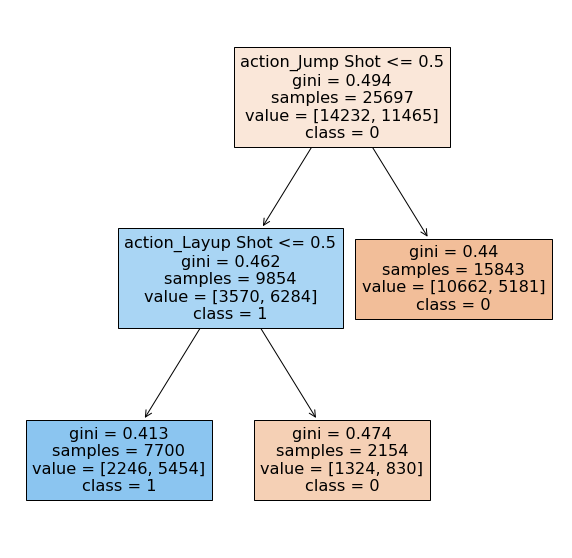

In [1153]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(dtreeCV.best_estimator_, 
                   feature_names=X_train_full.columns.tolist(),
                   class_names=['0','1'],
                   filled=True)
# fig.canvas.draw()
# figdata = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
# figdata = figdata.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# st.image(figdata)

In [1166]:
filename = 'dtree_model.pkl'

In [1132]:
pickle.dump(dtreeCV, open(filename, 'wb'))

In [1167]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(X_test)
print(result)

[[0.66469139 0.33530861]
 [0.66469139 0.33530861]
 [0.29168831 0.70831169]
 ...
 [0.29168831 0.70831169]
 [0.29168831 0.70831169]
 [0.29168831 0.70831169]]


(array([ 138.,    0., 2910.,  413.,    0.,    0.,    0.,    0.,    0.,
        1539.]),
 array([0.17597087, 0.22920496, 0.28243904, 0.33567312, 0.3889072 ,
        0.44214128, 0.49537536, 0.54860944, 0.60184353, 0.65507761,
        0.70831169]),
 <a list of 10 Patch objects>)

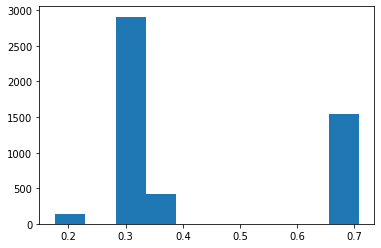

In [1134]:
plt.hist(loaded_model.predict_proba(X_test)[:,1])

In [132]:
loaded_model

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [2, 3, 4, 5],
                          'max_features': [2, 4, 8, 16, None],
          

In [1168]:
submission_df['shot_made_flag'] = loaded_model.predict_proba(X_test)[:,1].tolist()
submission_df[['shot_id','shot_made_flag']].sort_values(by='shot_id')

,shot_id,shot_made_flag
0,1,0.335309
7,8,0.335309
16,17,0.708312
19,20,0.708312
32,33,0.335309
...,...,...
30668,30669,0.335309
30680,30681,0.708312
30682,30683,0.708312
30686,30687,0.708312


In [1169]:
log_loss(y_valid, dtreeCV.predict_proba(X_valid)[:,1])

0.6261888017883225

In [1170]:
submission_df[['shot_id','shot_made_flag']].to_csv('Submissions_Kobe_dtree.csv',index=False)

In [133]:
loaded_model.predict(X_test_transformed)

array([1., 1., 1., ..., 1., 0., 0.])

### Random Forest

In [1140]:
param_grid = [
{'max_depth': [7], 'max_features':[5,10,15, None]}
]
RFclf = RandomForestClassifier(random_state=0, n_estimators=100)
RFclfCV = GridSearchCV(RFclf, param_grid, cv=10,
                       scoring='neg_log_loss',
                       return_train_score=True)
RFclfCV.fit(X_train_full, y_train_full)
print(RFclfCV.best_params_)
print([-1*RFclfCV.best_score_, RFclfCV.best_estimator_])

{'max_depth': 7, 'max_features': 15}
[0.6306881718615991, RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)]


In [1160]:
filename = 'rfclf_model.pkl'

In [1143]:
pickle.dump(RFclfCV, open(filename, 'wb'))

In [1161]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(X_test)
print(result)

[[0.62210322 0.37789678]
 [0.58227222 0.41772778]
 [0.31677536 0.68322464]
 ...
 [0.37698629 0.62301371]
 [0.37441516 0.62558484]
 [0.40288374 0.59711626]]


(array([  11.,    4.,   59.,  620., 2355.,  180.,  716.,  384.,  489.,
         182.]),
 array([0.05288695, 0.12600779, 0.19912864, 0.27224948, 0.34537033,
        0.41849117, 0.49161202, 0.56473286, 0.63785371, 0.71097455,
        0.78409539]),
 <a list of 10 Patch objects>)

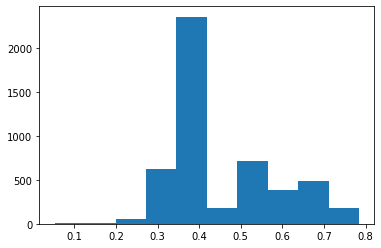

In [1141]:
plt.hist(RFclfCV.predict_proba(X_test)[:,1])

In [1163]:
submission_df['shot_made_flag'] = loaded_model.predict_proba(X_test)[:,1].tolist()
submission_df[['shot_id','shot_made_flag']].sort_values(by='shot_id')

,shot_id,shot_made_flag
0,1,0.377897
7,8,0.417728
16,17,0.683225
19,20,0.693997
32,33,0.371485
...,...,...
30668,30669,0.372856
30680,30681,0.574911
30682,30683,0.623014
30686,30687,0.625585


In [1164]:
log_loss(y_valid, loaded_model.predict_proba(X_valid)[:,1])

0.6192025013150276

In [1165]:
submission_df[['shot_id','shot_made_flag']].to_csv('Submissions_Kobe_rf.csv',index=False)

In [823]:
X_train_full.values

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int32)

### XGBoost

In [1157]:
param_grid = [
{'max_depth': [7], 'learning_rate':[0.012], 'subsample':[0.62], 'colsample_bytree':[0.6]}
]
xgbclf = XGBClassifier(random_state=0, n_estimators=200)
xgbclfCV = GridSearchCV(xgbclf, param_grid, cv=10,
                       scoring='neg_log_loss',
                       return_train_score=True)
xgbclfCV.fit(X_train_full, y_train_full)
print(xgbclfCV.best_params_)
print([-1*xgbclfCV.best_score_, xgbclfCV.best_estimator_])

{'colsample_bytree': 0.6, 'learning_rate': 0.012, 'max_depth': 7, 'subsample': 0.62}
[0.6373643301176488, XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.62,
              tree_method='exact', validate_parameters=1, verbosity=None)]


In [1114]:
filename = 'xgbclf_model.pkl'
pickle.dump(xgbclfCV, open(filename, 'wb'))

In [1106]:
clf_xgb = XGBClassifier(max_depth=7, learning_rate=0.012, n_estimators=500, subsample=0.62, colsample_bytree=0.6, seed=1)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1, subsample=0.62,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1107]:
log_loss(y_valid, clf_xgb.predict_proba(X_valid)[:,1])

0.6047754973575385

(array([  15.,   96.,  825., 2323.,  224.,  301.,  387.,  489.,  211.,
         129.]),
 array([0.10011569, 0.18038398, 0.26065227, 0.34092054, 0.42118883,
        0.5014571 , 0.5817254 , 0.6619937 , 0.74226195, 0.82253027,
        0.90279853], dtype=float32),
 <a list of 10 Patch objects>)

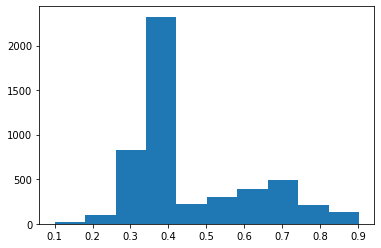

In [1159]:
plt.hist(xgbclfCV.predict_proba(X_test)[:,1])

In [1158]:
log_loss(y_valid, xgbclfCV.predict_proba(X_valid)[:,1])

0.5975706300136528

In [1109]:
submission_df['shot_made_flag'] = clf_xgb.predict_proba(X_test)[:,1].tolist()
submission_df[['shot_id','shot_made_flag']].sort_values(by='shot_id')

,shot_id,shot_made_flag
0,1,0.368480
7,8,0.409626
16,17,0.685697
19,20,0.742545
32,33,0.352691
...,...,...
30668,30669,0.376845
30680,30681,0.399913
30682,30683,0.819715
30686,30687,0.825925


(array([  19.,  108., 1004., 2035.,  366.,  267.,  383.,  492.,  183.,
         143.]),
 array([0.04162556, 0.1349253 , 0.22822507, 0.32152483, 0.41482458,
        0.5081243 , 0.6014241 , 0.69472384, 0.7880236 , 0.88132334,
        0.9746231 ], dtype=float32),
 <a list of 10 Patch objects>)

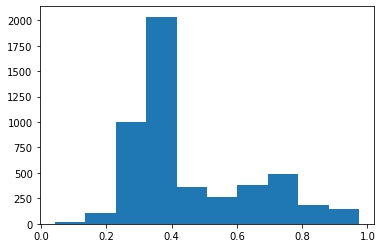

In [1108]:
plt.hist(clf_xgb.predict_proba(X_test)[:,1])

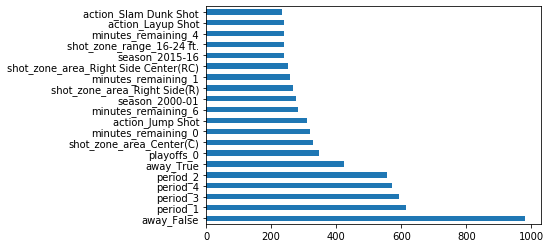

In [1110]:
pd.Series(clf_xgb.get_booster().get_score()).sort_values(ascending=False).head(20).plot.barh()

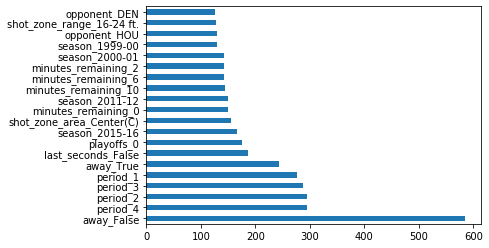

In [1113]:
pd.Series(xgbclfCV.best_estimator_.get_booster().get_score()).sort_values(ascending=False).head(20).plot.barh()

In [1061]:
submission_df['shot_made_flag'] = xgbclfCV.predict_proba(X_test)[:,1].tolist()
submission_df[['shot_id','shot_made_flag']].sort_values(by='shot_id')

,shot_id,shot_made_flag
0,1,0.385998
7,8,0.434068
16,17,0.675181
19,20,0.712136
32,33,0.380772
...,...,...
30668,30669,0.388700
30680,30681,0.483686
30682,30683,0.772683
30686,30687,0.772611


In [1111]:
submission_df[['shot_id','shot_made_flag']].to_csv('Submissions_Kobe_xgb.csv',index=False)

In [1211]:
input_df = pd.DataFrame(columns=X_test.columns.tolist(), index=[0]).fillna(0)
input_df

,minutes_remaining_0,minutes_remaining_1,minutes_remaining_10,minutes_remaining_11,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,minutes_remaining_5,minutes_remaining_6,minutes_remaining_7,...,action_Running Jump Shot,action_Running Layup Shot,action_Slam Dunk Shot,action_Step Back Jump shot,action_Tip Shot,action_Turnaround Bank shot,action_Turnaround Fadeaway shot,action_Turnaround Jump Shot,away_False,away_True
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1225]:
pd.DataFrame(columns=X_test.columns.tolist(), index=[0]).fillna(0).to_csv('empty_df.csv',index=False)

In [1226]:
pd.read_csv('empty_df.csv')

,minutes_remaining_0,minutes_remaining_1,minutes_remaining_10,minutes_remaining_11,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,minutes_remaining_5,minutes_remaining_6,minutes_remaining_7,...,action_Running Jump Shot,action_Running Layup Shot,action_Slam Dunk Shot,action_Step Back Jump shot,action_Tip Shot,action_Turnaround Bank shot,action_Turnaround Fadeaway shot,action_Turnaround Jump Shot,away_False,away_True
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1223]:
features = ['empty_df.csvutes_remaining','last_seconds','period', 'playoffs', 'season', 'shot_distance',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'opponent', 'action','away']

input_df = pd.DataFrame(columns=X_test.columns.tolist(), index=[0]).fillna(0)

## minutes_remaining=10
last_seconds='False'
period='1'
playoffs='0'
season='2005-06'
shot_distance='8'
shot_type='2PT Field Goal'
shot_zone_area = 'Right Side(R)'
shot_zone_basic = 'Mid-Range'
shot_zone_range = '16-24 ft.'
opponent='TOR'
action='Layup'
away='False'
for f in features:
    input_df[f+'_'+str(eval(f))]=1
# input_df['minutes_remaining_'+str(minutes_remaining)]=1
# input_df['last_seconds_'+str(last_seconds)]=1
xgbclfCV.predict_proba(input_df)[:,1]

array([0.616219], dtype=float32)

In [1214]:
eval('season')

'2005-06'

In [1215]:
input_df

,minutes_remaining_0,minutes_remaining_1,minutes_remaining_10,minutes_remaining_11,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,minutes_remaining_5,minutes_remaining_6,minutes_remaining_7,...,action_Running Jump Shot,action_Running Layup Shot,action_Slam Dunk Shot,action_Step Back Jump shot,action_Tip Shot,action_Turnaround Bank shot,action_Turnaround Fadeaway shot,action_Turnaround Jump Shot,away_False,away_True
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


array([0.37578136], dtype=float32)

In [1195]:
X_test

,minutes_remaining_0,minutes_remaining_1,minutes_remaining_10,minutes_remaining_11,minutes_remaining_2,minutes_remaining_3,minutes_remaining_4,minutes_remaining_5,minutes_remaining_6,minutes_remaining_7,...,action_Running Jump Shot,action_Running Layup Shot,action_Slam Dunk Shot,action_Step Back Jump shot,action_Tip Shot,action_Turnaround Bank shot,action_Turnaround Fadeaway shot,action_Turnaround Jump Shot,away_False,away_True
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
32,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
30680,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
30682,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
30686,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0


In [1194]:
xgbclfCV.predict_proba(X_test)

array([[0.6164457 , 0.38355428],
       [0.58197075, 0.41802925],
       [0.30951798, 0.690482  ],
       ...,
       [0.23368126, 0.76631874],
       [0.21856207, 0.78143793],
       [0.42092186, 0.57907814]], dtype=float32)

In [782]:
pd.DataFrame(xgbclfCV.best_estimator_.feature_importances_,df.drop('shot_made_flag', axis=1).columns.tolist()).sort_values(by=0,ascending=False).head(10)


,0
action_Jump Shot,0.292804
action_Layup Shot,0.097058
shot_zone_basic_Restricted Area,0.050729
action_Running Jump Shot,0.028365
shot_distance_0,0.026655
action_Pullup Jump shot,0.020498
action_Slam Dunk Shot,0.019918
action_Driving Layup Shot,0.018673
action_Driving Dunk Shot,0.016996
action_Jump Bank Shot,0.016980
